# Statistical Phase Estimation

In this tutorial, we will go over how to execute statistical phase estimation (SPE) using QURI Algo and QURI VM.

## Overview

[SPE](https://arxiv.org/abs/2409.07749) is an algorithm that is used to estimate the eigenenergies of a problem Hamiltonian. It does so by performing a Hadamard test on a trial wave-function, resulting in a measurable signal that can be used to infer the wave-functions spectral density. If this wave-function has a significant overlap with the true ground state of the system, the ground state energy should make a significant contribution to the spectral density. The following propoerties makes SPE an attractive algorithm in EFTQC

- Good circuit depth scaling compared to FTQC algorithms
- The run-time scales with the energy accuracy $\epsilon$ as $\mathcal{O}(\epsilon^{-1})$
- Noise resilience

In this notebook we will introduce all of the pieces needed to run SPE. In order, this notebook will


1. Explain the LT22 and Gaussian filter variants of SPE and showcase their implementations in QURI Algo
2. Instruct in the use of QURI Parts' noise models and showcase the robustness of SPE to noise based on the [STAR architecture](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.010337)
3. Estimate the Fidelity of the Hadamard test circuits used in SPE after transpilation to the STAR architecture and introduce QURI VM.

## Prerequisites

We do not go into great detail about the following topics, but they will be part of this notebook.

- [Molecular Hamiltonian generation](https://quri-parts.qunasys.com/docs/tutorials/quantum-chemistry/hamiltonian/hamiltonian/)
- [Noisy simulations](https://quri-parts.qunasys.com/docs/tutorials/basics/noise_error/)
- [Circuit factories](../../../tutorials/1_quri-algo/0_basics/0_time_evolution/index.md)
- [Quri Algo Estimators](../../../tutorials/1_quri-algo/0_basics/1_estimator/index.md)

## Set up the system

Before running SPE we briefly introduce some of the building blocks we need. We will here show how to

- Define a $\textup{H}_2$ molecule
- Set up programming abstractions needed for SPE using QURI Algo
- Verify that they behave as expected by conducting the Hadamard test

We first set up the problem using PySCF and quri-parts. PySCF is used to define the molecular geometry and then give us the spin-restricted Hartree-Fock ground state solution to the molecular Hamiltonian. Then the second quantized Hamiltonian is generated by calculating the electron integrals, which is then converted to a qubit operator. For this we use the `quri_parts.openfermion` and `quri_parts.pyscf` modules.

In [ ]:
from pyscf import gto, scf
from quri_algo.problem import QubitHamiltonian
from quri_parts.pyscf import get_spin_mo_integrals_from_mole # >= 0.22.0
from quri_parts.openfermion import get_qubit_mapped_hamiltonian # >= 0.22.0


# Prepare Hamiltonian
mole = gto.M(atom="H 0 0 0; H 0 0 1")
mf = scf.RHF(mole).run(verbose=0)
hamiltonian, mapping = get_qubit_mapped_hamiltonian(
    *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
)

Before moving on, we compute some exact system characteristics, e.g. the exact ground state energy and the exact energy gap between the ground state and the first excited state. To this end, we first convert the Hamiltonian to a sparse matrix that we can diagonalize using scipy's sparse linear algebra library.

In [ ]:
import numpy as np
from quri_parts.core import get_sparse_matrix # >= 0.22.0

vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

EXACT_GS_ENERGY = np.min(vals)
EXACT_GAP = np.abs(vals[np.argsort(vals)][:2] @ [1, -1])

print("E_0:", EXACT_GS_ENERGY)
print("Delta:", EXACT_GAP)

E_0: -1.1011503302326187
Delta: 0.3552785371970515


To perform further computations, we need to encode our problem into some circuit that represents some operator function of our problem. For example in SPE, to estimate the ground state of a Hamiltonian, we need to encode our Hamiltonian into a controlled time evolution circuit. Here, we choose to do the time evolution with Trotterization. To do this, we wrap the hamiltonian into `QubitHamilton` for encoding into a circuit later.

`QubitHamiltonian` can be seen as a generalization of the `Operator` class from QURI Parts, containing both the terms of a qubit operator and the number of qubits. This makes it convenient when contructing a class hierarchy with quantum circuit factories intended to represent time-evolution and other _problem_ defined quantum circuit constructs.

In [ ]:
hamiltonian = QubitHamiltonian(mapping.n_qubits, hamiltonian)

### Circuit factories

As a direct example of the aforementioned circuit factories we consider the `TrotterControlledTimeEvolutionCircuitFactory`. As the name suggests this is a circuit factory that instance time-evolution circuits based on the Trotter-Suzuki decomposition. It needs a `QubitHamiltonian` which serves as the generator of time evolution, as well as the number of Trotter steps. Details of this factory are explained in [circuit factories](../../../tutorials/1_quri-algo/0_basics/0_time_evolution/index.md).

In [ ]:
from quri_parts.circuit import draw_circuit # >= 0.22.0
from quri_algo.circuit.time_evolution.trotter_time_evo import (
    TrotterControlledTimeEvolutionCircuitFactory,
)

trotter_concotrolled_time_evo_circuit_factory = (
    TrotterControlledTimeEvolutionCircuitFactory(hamiltonian, n_trotter=30)
)

# Time-evolution with t=1
c_time_evo = trotter_concotrolled_time_evo_circuit_factory(evolution_time=1)

draw_circuit(c_time_evo, line_length=10000)

   ___     ___     ___     ___             ___     ___             ___                     ___     ___             ___             ___             ___             ___             ___             ___     ___     ___     ___     ___             ___     ___             ___                     ___     ___             ___             ___             ___             ___             ___             ___     ___     ___     ___     ___             ___     ___             ___                     ___     ___             ___             ___             ___             ___             ___             ___     ___     ___     ___     ___             ___     ___             ___                     ___     ___             ___             ___             ___             ___             ___             ___     ___     ___     ___     ___             ___     ___             ___                     ___     ___             ___             ___             ___             ___             ___             ___  

As seen above, the time-evolution is composed of a series of Pauli rotations. Since it is a controlled time-evolution, each term in the Hamiltonian results in two Pauli rotations, i.e.
$$
C R_P(\theta) = R_{Z\otimes P}\left(-\theta/2\right) R_{I\otimes P} \left(\theta/2\right),
$$
where $C R_P$ is the controlled Paui rotation gate with rotation generator $P$.

We represent these Pauli rotations as single quantum gates, however to run them on a real device, in most cases, they need to first be transpiled to a series of two-qubit gates and single qubit rotations. Later in this notebook, we will show how this is done to conform to the [STAR architecture](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.010337).

### Estimator

The SPE algorithm requires an esimtation of $\langle e^{-iHt} \rangle$ on different evolution time $t$. Follow the [estimator tutorial](../../../tutorials/1_quri-algo/0_basics/1_estimator/index.md), we build the exact estimator and another one that based on Hadamard test with Trotterized time evolution operator.



In [ ]:
from quri_algo.core.estimator.time_evolution import ExactTimeEvolutionExpectationValueEstimator
from quri_algo.core.estimator.time_evolution import TrotterTimeEvolutionHadamardTest

from quri_parts.qulacs.sampler import create_qulacs_vector_sampler

sampler = create_qulacs_vector_sampler()
exact_time_evolution_estimator = ExactTimeEvolutionExpectationValueEstimator(
    hamiltonian, vals, vecs
)
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(
    hamiltonian, sampler, n_trotter=50
)

We then build a state as an example. We choose a computational basis superposition state.

In [ ]:
from quri_parts.core.state import quantum_state, comp_basis_superposition

state = comp_basis_superposition(
    quantum_state(mapping.n_qubits, bits=0b0011),
    quantum_state(mapping.n_qubits, bits=0b1100),
    7 / 20,
    0,
)

This state is chosen such that its overlap with the exact ground state vector is about 75%.

In [ ]:

from quri_parts.qulacs import evaluate_state_to_vector # >= 0.22.0

gs_overlap = np.abs(evaluate_state_to_vector(state).vector @ vecs[:, 0])**2
print(f"Overlap between the chosen state and the exact grounds state vector: {gs_overlap: .1e}")

Overlap between the chosen state and the exact grounds state vector:  7.5e-01


Let's compute $\langle e^{-iHt} \rangle$ with the state above. First we use the exact estimator, which is based on matrix multiplication

In [ ]:
print(
    f"The time-evolution expectation value is {exact_time_evolution_estimator(state, evolution_time=5.).value}"
)
print(
    f"The trotter time-evolution expectation value is {trotter_time_evolution_estimator(state, evolution_time=5., n_shots=int(1e6)).value}"
)

The time-evolution expectation value is (0.7803970841187445-0.5734363633936669j)
The trotter time-evolution expectation value is (0.781916-0.571636j)


As we shall see below, this Hadamard test is essential to SPE. The tools provided above can be used to dictate whether the Hadamard test should be done exactly or with a Trotterized quantum circuit implementation based on sampling.

## Executing statistical phase estimation

SPE has two main variants, which we will explore in this notebook. The first one is by Lin and Tong ([LT22](https://link.aps.org/doi/10.1103/PRXQuantum.3.010318)) which introduced SPE in the context of early fault tolerant devices for the first time. We also explore a variant of it by Wang et. al. which we refer to as [Gaussian filter](https://quantum-journal.org/papers/q-2023-11-06-1167/). The chief difference between the two is that the signal that is generated uses a convolution function that is either a Heaviside step functino (LT22) or a Gaussian (Gaussian filter).

### Introducing the signal and convolution functions

SPE tries to obtain the spectrum of a Hamiltonian $H = \sum_{i} \lambda_i \ket{\lambda_i} \bra{\lambda_i}$ by using a trial state $|\psi\rangle$. $|\psi\rangle$`s overlap with the eigenstates $|\lambda_i\rangle$ of the Hamiltonian $H$ is $p_{i} = |\langle \lambda_i| \psi\rangle|^2$. In terms of this overlap the spectral density function is

$$
\varrho(x) = \sum_{i} p_i\delta(x-\lambda_i\tau),
$$

where $\delta(x)$ is the Dirac delta function and $\tau$ is a dimensionless scaling parameter applied to the Hamiltonian, that we introduce through the algorithm itself.

Depending on the concrete implementation of SPE, we may never directly resolve the spectral density function exactly, but we construct a signal that will have features in common with it. This is done by first picking a convolution function $F(x)$ such that when the spectral density $\varrho(x)$ is convolved by $F(x)$, the eigenvalues $\lambda_i$ manifest as special points in the resulting signal

$$
(F * \varrho)(x) = \int_{-T}^T F(y)\varrho(y-x)dy =\sum_{i}p_{i}F(x-\lambda_i \tau).
$$

Here $T$ defines the support of $F(x)$, while $\tau$ determines where the eigenvalues are laid out in the resulting signal. We here skip the full derivation, but the interested reader is directed to [our paper](https://arxiv.org/abs/2409.07749) summarizing these ideas while providing benchmarks of SPE. Here it suffices to say that we can express this convolution in terms of the Fourier components $\tilde{F}$ as

$$
(F * \varrho)(x)\approx \sum_{n=0}^{N-1}e^{ik_n x} \widetilde{F}(k_n) \langle e^{-ik_n\tau H}\rangle \equiv Z_F(x;\tau).
$$

Here $N$ is a parameter that gives the upper bound on the number of Fourier modes included in the algorithm. From this expression and the preceeding discussion we see that this signal can be recovered using a quantum processor. The expectation value of the time-evolution operator can be evaluated using the Hadamard test. The only other component we need is a Fourier transform of the convolution function. The convolution function itself can be chosen depending on desired algorithm scaling.

The convolution function is only approximately represented in the convolution integral because of the cut-off $N$. This defines a trade-off between the accuracy of the convolution function and the run-time needed to accurately represent time-evolution by $k_N \tau$.

Finally, the scaling of the integrand with $\tilde{F}(k_n)$ is not carried out by direct multiplication. Instead $\tilde{F}(k_n)$ is sampled to determine the number of samples used to evaluate $\langle e^{-ik_n\tau H}\rangle$.

In the following we will show how to proceed with QURI Algo's SPE implementation with the LT22 variant is chosen in which $F$ is a Heaviside step-function.

### The LT22 algorithm

We start with the LT22 variant. First we have to specify: 

1. $d_{\text{max}}$: the maximum index of the Fourier modes considered, 
2. $\delta$: a parameter that controls the interval within which the error of the Fourier transformed Heaviside step function is bounded. 
3. $N_{\text{sample}}$: Number of samples used to estimate the signal function $Z_F(x; \tau)$.

These parameters specifies the step function $F$ used to convolute with the spectral density function $\varrho$ and are wrapped inside `StepFunctionParam`

In [ ]:
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
d_max = 1000
delta = 1e-4
n_sample = 10000

signal_param = StepFunctionParam(d=d_max, delta=delta, n_sample=n_sample)

Next we normalize the spectrum by a factor of $\tau$. It is a dimensionless factor that effectively scales first axis of the resulting signal, thus acting as a parameter for fine-graining the signal. The consequence of choosing a small $\tau$ is that the signal itself may not include the ground state energy or other eigenenergies of interest, however, choosing it too large will render the resolution too low to effectively distinguish different peaks in the signal. Here we pick $\tau = 1/20$.

In [ ]:
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE
from pprint import pprint

tau = 1 / 20
lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=tau)

The post processing part of the algorithm attempts to invert the signal function by finding the point where the height of the signal function takes the value of $\frac{3\eta}{4}$. Here, we choose $\eta$ to be 0.4. (One can rerun only the classical post processing part by changing $\eta$)

In [ ]:
eta = 0.4

spe_result = lt22_algorithm(state, signal_param, eta)
pprint(spe_result)

SPEResult(phase=-0.0551296981525953,
          signal_functions=[<quri_algo.algo.phase_estimation.spe.utils.signal.SPEDiscreteSignalFunction object at 0x7f50a582c350>])


The algorithm returns a `SPEResult` object which includes the estimated phase and the signal function $Z_F(x;\tau)$, from which the phase is extracted.

In [ ]:
lt22_gs_energy = spe_result.phase / tau
print(f"The obtained ground state energy is {lt22_gs_energy}")
print(f"The error is = {abs(lt22_gs_energy - np.min(vals))}")

The obtained ground state energy is -1.102593963051906
The error is = 0.0014436328192872772


Common performance indicators of phase algorithms are:
1. $T_{\text{max}}$: Maximal evolution time used in the algorithm.
2. $T_{\text{total}}$: The absolute value sum of the evolution time used in the phase estimation algorithm.

These indicators can be computed by passing in the list of signal functions to the `SPEGSEERecorder`.

In [ ]:
from quri_algo.algo.phase_estimation.spe.utils.recorder import SPEGSEERecorder

resource = SPEGSEERecorder(spe_result.signal_functions, tau)
pprint(resource)

SPEGSEERecorder(max_evolution_time=49.95,
                total_evolution_time=101319.99999999999,
                n_shots=20000)


The signal function $Z_F(x; \tau)$ is automatically saved in the `SPEResult` object, where we can retrieve and plot out the signal at any derivative order.

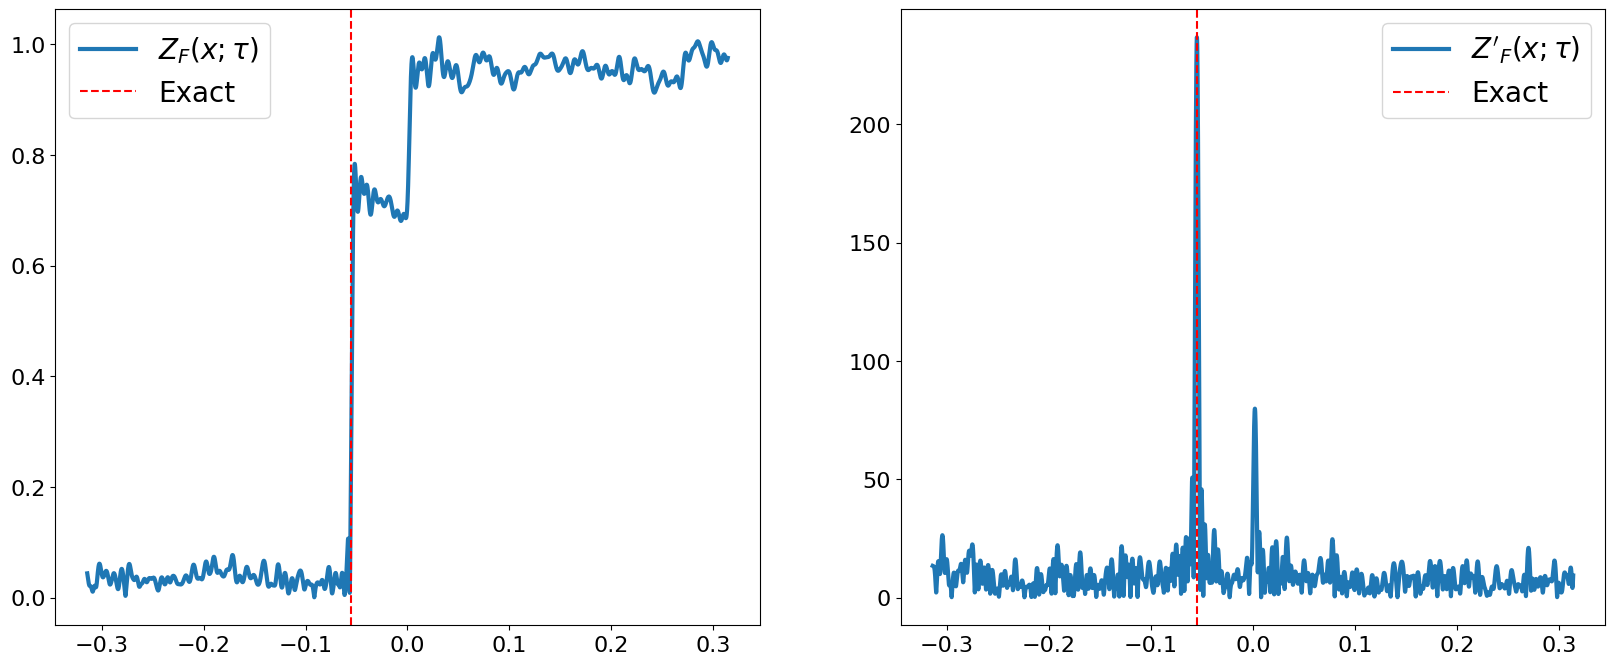

In [ ]:
import matplotlib.pyplot as plt

xs = np.linspace(-np.pi / 10, np.pi / 10, 10000)
signal_func = spe_result.signal_functions[0]
ys = np.abs(signal_func(xs, derivative_order=0))
yds = np.abs(signal_func(xs, derivative_order=1))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(
    xs,
    ys,
    lw=3,
    label=r"$Z_F(x; \tau)$",
)
ax1.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax1.legend(fontsize=20)

ax2.plot(xs, yds, lw=3, label=r"$Z'_F(x; \tau)$")
ax2.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax2.legend()
ax2.legend(fontsize=20)

for ax in [ax1, ax2]:
    ax.tick_params(axis="both", which="major", labelsize=16)

fig.set_size_inches(20, 8)
plt.show()

As seen above, SPE with the step function convolution function results in fairly distinguishable signatures of the spectral density function peaks. These appear as steps in the raw signal and as peaks in the first order derivative. If the calculation is carried out exactly, the first order derivative is seen to result in the actual spectral density. However, due to sampling noise and the limit on Fourier modes the resulting signal carries significant noise.

That being said, for the above signal these errors do not appear to significantly alter the centroids of the resulting peaks. As long as the overlap is such that each peak retains a height well above the noise floor it appears that LT22 is robust to noise.

### Gaussian

The Gaussian filter variant of SPE is overall similar to LT22 and the flow is the same apart from some classical post-processing steps. However, Gaussian filter is sensitive to the parameter choices made since the eigenenergies manifest as Gaussians in the returned signal. The standard deviation of each Gaussian for instance influences the energy resolution possible. Below we define a function that returns optimal metaparameters based on [the paper by Wang et. al.](https://quantum-journal.org/papers/q-2023-11-06-1167/)

In [ ]:
from typing import Optional
from quri_algo.algo.phase_estimation.spe import GaussianParam
from quri_algo.algo.phase_estimation.spe.gaussian import GaussianFittingGSEE
from quri_algo.algo.phase_estimation.spe.utils.fourier.gaussian_coefficient import (
    GaussianSampler,
)


def get_recommended_gaussian_parameter(
    gap: float,
    eps: float,
    overlap: float,
    delta: float,
    n_discretize: int,
    max_shot_limit: Optional[int] = None,
) -> tuple[GaussianParam, int]:
    """The recommended parameters to execute the Gaussian SPE.

    Args:
        gap: The (approximate) energy gap between the ground state the 1st excited state.
        eps: The target accuracy one wants to reach with Gaussian SPE.
        overlap: The (approximate) overlap of the input state and the exact ground state.
        delta: The tolerable failure probability of the Gaussian SPE.
        n_discretize: Number of discretization steps one wants to use to perform the 
            convolution integration. This also corresponds to the number of evolution time
            steps one can sample from.
        max_shot_limit: the maximal number of shots.
    """
    Delta = gap
    sigma = np.min(
        [
            0.9 * Delta / np.sqrt(2 * np.log(9 * Delta * eps**-1 * overlap**-1)),
            0.2 * Delta,
        ]
    )
    eps_tilde = 0.1 * eps * overlap / (np.sqrt(2 * np.pi) * sigma**3)
    T = (
        np.pi**-1
        * sigma**-1
        * np.sqrt(2 * np.log(8 * np.pi**-1 * eps_tilde**-1 * sigma**-2))
    )
    M = np.ceil(sigma / eps) + 1
    fk = GaussianSampler(T, n_discretize, sigma).fourier_coefficients
    shot_const = np.abs(fk).sum()
    S = int(
        2 * np.pi * sigma **2 *shot_const**2 * np.ceil(np.log(4 * M / (delta / 2)) / (eps) ** 2)
    )
    if max_shot_limit is not None:
        S = np.min([S, max_shot_limit])
    return (
        GaussianParam(T, n_discretize, sigma, S),
        M,
    )

In order to use this, we must provide an upper bound on the excitation gap of the system. Although we can obtain it fairly easily for the above $\textup{H}_2$ Hamiltonian, we do not in general expect to be able to solve the problem exactly. So we will instead use the coupled cluster excitation energy as a rough estimate. We can calculate it by using the [equation of motion CCSD](https://pyscf.org/user/cc.html) using PySCF

In [ ]:
from pyscf import cc

ccsd = cc.CCSD(mf).run()
e_ee, _ = ccsd.eeccsd(nroots=2)
print("EOMCCSD excitation energy is:", e_ee[0])

E(CCSD) = -1.101150330244479  E_corr = -0.03504168092654206


EOMCCSD excitation energy is: 0.355278537208911


We now obtain the parameters. Note that the gap and the desired accuracies are all multiplied by a factor of $\tau$ because $\tau$ shrinks the distance between each eigen energy.

In [ ]:
gaussian_param, n_scanned_energy = get_recommended_gaussian_parameter(
    gap=e_ee[0] * tau,
    eps=1e-3 * tau,
    overlap=0.5,
    delta=1e-3,
    n_discretize=1000,
    max_shot_limit=1e7
)
pprint(gaussian_param)

GaussianParam(T=382.4927291240873,
              N=1000,
              sigma=0.0035527853720891105,
              n_sample=10000000.0)


Before launching the Gaussian fitting variation of SPE let's see if we can get a rough idea of what the eigenenergies are with LT22 and then based on that refine the search criteria of the Gaussian fitting method.

In [ ]:
rough_signal_param = StepFunctionParam(d=100, delta=1e-4, n_sample=10000)
rough_energy = lt22_algorithm(state, rough_signal_param, eta=0.5).phase / tau
print(f"Rough energy estimation by LT22 = {rough_energy}")
print(f"Energy error = {rough_energy - np.min(vals)}")

Rough energy estimation by LT22 = -1.1170195141804962
Energy error = -0.015869183947877508


This should help narrow down the interval to search for the true ground state energy. The classical post processing algorithm aims to find a Gaussian function that best fits the signal function near the rough estimate. So, one needs to specify the number of points and the range to perform the fitting. The range is specified by the equation:

$$
x \in \left[E_{\text{rough estimate}} - n_\sigma \frac{\sigma}{4}, E_{\text{rough estimate}} + n_\sigma \frac{\sigma}{4}\right]
$$

Here we pick $n_{\sigma}$ to be 10 for the fitting.

In [ ]:
gaussian_spe_algorithm = GaussianFittingGSEE(trotter_time_evolution_estimator, tau)
search_range = gaussian_spe_algorithm.get_recommended_search_range(
    rough_energy * tau, n_scanned_energy, gaussian_param.sigma, n_sigma=10
)
gaussian_result = gaussian_spe_algorithm(state, gaussian_param, search_range, eta=0.5)
gaussian_energy = gaussian_result.phase / tau
print("Gaussian energy:", gaussian_energy)
print("Energy error:", np.abs(gaussian_energy - EXACT_GS_ENERGY))

Gaussian energy: -1.1007217654167987
Energy error: 0.0004285648158199873


In [ ]:
gaussian_resource = SPEGSEERecorder(gaussian_result.signal_functions, 2 * np.pi * tau)
pprint(gaussian_resource)

SPEGSEERecorder(max_evolution_time=75.22243537652074,
                total_evolution_time=224539776.137231,
                n_shots=20000000)


As opposed to LT22, the Gaussian filter method ideally results in a signal which contains a set of Gaussians that are centered on each eigenvalue. Here we have done enough pre-processing to narrow down the centroid quite a lot and will only focus on the ground state energy. The Gaussian will be flat at its peak, and because of that we can obtain the ground state energy by finding the zeros of the first derivative of the signal.

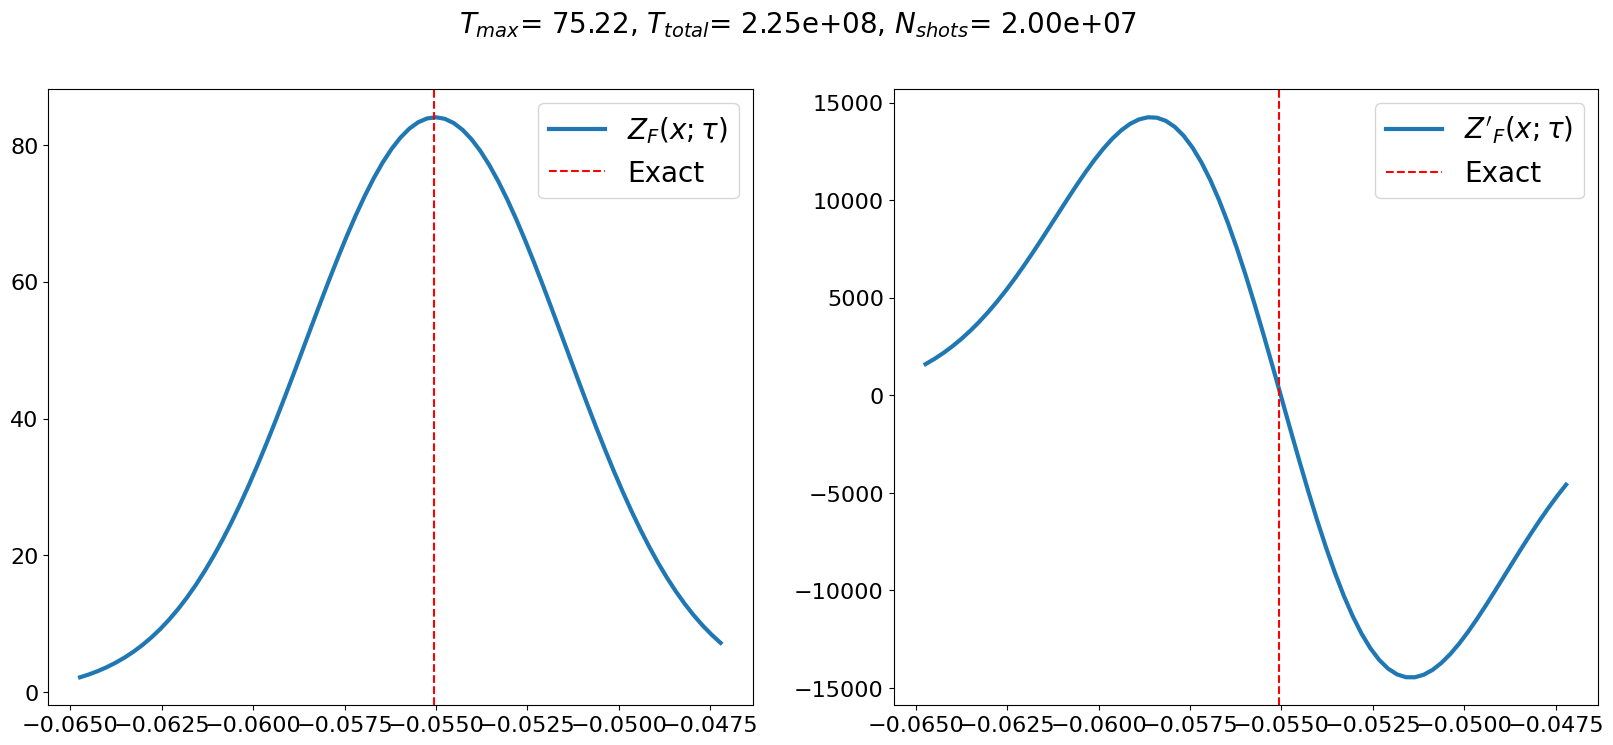

In [ ]:
xs = search_range
signal_func = gaussian_result.signal_functions[0]
ys = np.abs(signal_func(xs, derivative_order=0))
yds = np.real(signal_func(xs, derivative_order=1))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(
    xs,
    ys,
    lw=3,
    label=r"$Z_F(x; \tau)$",
)
ax1.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax1.legend(fontsize=20)

ax2.plot(xs, yds, lw=3, label=r"$Z'_F(x; \tau)$")
ax2.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax2.legend()
ax2.legend(fontsize=20)
# plt.hlines()

for ax in [ax1, ax2]:
    ax.tick_params(axis="both", which="major", labelsize=16)

fig.set_size_inches(20, 8)
fig.suptitle(
    "$T_{max}$="
    f"{gaussian_resource.max_evolution_time: .2f}, "
    "$T_{total}$="
    f"{gaussian_resource.total_evolution_time: .2e}, "
    "$N_{shots}$="
    f"{gaussian_resource.n_shots: .2e}",
    size=20,
)
plt.show()

## Executing statistical phase estimation on noisy devices

Finally, we show how to obtain estimates of the performance in a noisy environment. Here we will use [transpilers from QURI Parts](https://quri-parts.qunasys.com/docs/tutorials/basics/transpiler/#transpiler-interface) to optimize the circuit somewhat. Most of these implement some minor circuit optimizations, such as removing gates or combinations of gates that amount to identity operations, but some of them are essential for device simulation, such as the decomposition of Pauli rotations to actual gates implemntable by a quantum processor. This is done through `PauliRotationDecomposeTranspiler`. Finally we combine them into a single `SequentialTranspiler`. The transpiler combination we choose is tailored to the STAR architecture, which is an EFTQC architecture with partial error correction. Later we evaluate the cost of running the time-evolution circuit needed for SPE on the STAR architecture.

In [ ]:
from quri_vm import VM
from quri_parts.backend.devices import star_device
from quri_parts.backend.units import TimeUnit, TimeValue

logical_qubit_count = 5
p_phys = 1e-4
code_distance = 9
qec_cycle = TimeValue(1, TimeUnit.MICROSECOND)

star_property = star_device.generate_device_property(
    logical_qubit_count, code_distance, qec_cycle, p_phys
)

star_vm = VM.from_device_prop(prop=star_property)

The circuit factory for the time-evolution accepts a transpiler argument which is applied to the circuit. With this in mind we instantiate the circuit factory below and obtain the resulting set of gates with

In [ ]:
star_evolution_circuit_factory = TrotterControlledTimeEvolutionCircuitFactory(
    hamiltonian, n_trotter=50
)

print("The set of gates used by SPE after transpilation to the STAR architecture is")
set([g.name for g in star_vm.transpile(star_evolution_circuit_factory(10)).gates])

The set of gates used by SPE after transpilation to the STAR architecture is


{'CNOT', 'H', 'RZ', 'S'}

### Noise model

For the noise model we choose a simplified model with the assumption that the Clifford gates, which undergo surface code error correction under the STAR architecture, can be assumed to be ideal, while the non-Clifford `Rz` gate is subject only to post-selection, whereby the resulting phase flip error probability based on device error probability $p_\textup{phys}$ becomes:

$$P_L = \left(1 - \frac{2 p_{\textup{phys}}}{15} \right)^2$$

### Noisy LT22 simulation

Finally, we perform the noisy simulation using QURI Parts

In [ ]:
rough_signal_param = StepFunctionParam(d=100, delta=1e-4, n_sample=10000)

noisy_trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(
    qubit_hamiltonian=hamiltonian,
    sampler=star_vm.sample,
    n_trotter=50,
)

Comparison with the exact time evolution and the noise-free Trotterized time-evolution shows that noise has a significant effect on the estimation of the time-evolution unitary expectation value.

In [ ]:
evolution_time = 5.0
print(
    "Exact time evolution <e^{-iHt}>:",
    exact_time_evolution_estimator(state, evolution_time).value,
)
print(
    "Trotter time evolution <e^{-iHt}>:",
    trotter_time_evolution_estimator(state, evolution_time, 10000).value,
)
print(
    "Noisy Trotter time evolution <e^{-iHt}>:",
    noisy_trotter_time_evolution_estimator(state, evolution_time, 10000).value,
)

Exact time evolution <e^{-iHt}>: (0.7803970841187445-0.5734363633936669j)
Trotter time evolution <e^{-iHt}>: (0.7768-0.5656j)


Noisy Trotter time evolution <e^{-iHt}>: (0.7856-0.5804j)


Based on this inaccuracy it is interesting to see what the resulting signal will look like when used in SPE. All we have to do is pass the noisy trotter time evolution estimator to the LTE algorithm.

In [ ]:
noisy_lt22 = SingleSignalLT22GSEE(noisy_trotter_time_evolution_estimator, tau=tau)

In [ ]:
noisy_lt22_result = noisy_lt22(state, rough_signal_param, eta=0.5)
noisy_lt22_energy = noisy_lt22_result.phase / tau
print("Noisy LT22 energy:", noisy_lt22_energy)
print("Energy error:", noisy_lt22_energy - EXACT_GS_ENERGY)

Noisy LT22 energy: -1.1119544070438636
Energy error: -0.010804076811244956


In [ ]:
noisy_lt22_resource = SPEGSEERecorder(noisy_lt22_result.signal_functions, tau)
pprint(noisy_lt22_resource)

SPEGSEERecorder(max_evolution_time=4.95,
                total_evolution_time=13356.3,
                n_shots=20000)


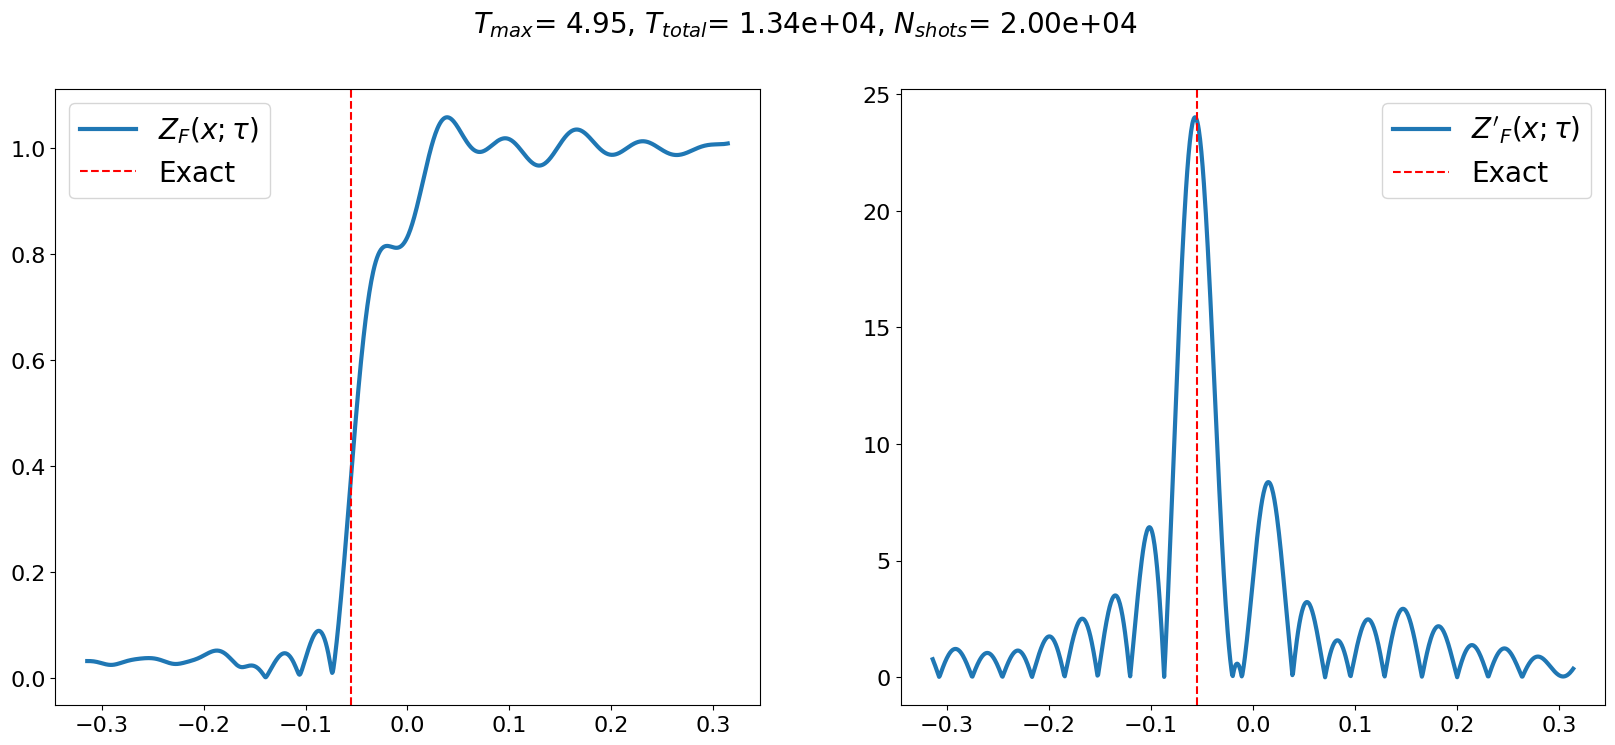

In [ ]:
xs = np.linspace(-np.pi / 10, np.pi / 10, 1000)
signal_func = noisy_lt22_result.signal_functions[0]
ys = np.abs(signal_func(xs, derivative_order=0))
yds = np.real(signal_func(xs, derivative_order=1))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(
    xs,
    ys,
    lw=3,
    label=r"$Z_F(x; \tau)$",
)
ax1.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax1.legend(fontsize=20)

ax2.plot(xs, np.abs(yds), lw=3, label=r"$Z'_F(x; \tau)$")
ax2.axvline(np.min(vals) * tau, color="red", linestyle="--", label="Exact")
ax2.legend()
ax2.legend(fontsize=20)

for ax in [ax1, ax2]:
    ax.tick_params(axis="both", which="major", labelsize=16)

fig.set_size_inches(20, 8)
fig.suptitle(
    "$T_{max}$="
    f"{noisy_lt22_resource.max_evolution_time: .2f}, "
    "$T_{total}$="
    f"{noisy_lt22_resource.total_evolution_time: .2e}, "
    "$N_{shots}$="
    f"{noisy_lt22_resource.n_shots: .2e}",
    size=20,
)
plt.show()

This result is remarkable as it shows that even in an environment with significant noise, it is still possible to accurately determine the ground state energy.

### Resource estimation and circuit evaluation

The noise simulations carried out so far have been based on a simplified model of the partial error correction of the STAR architecture. While it is enough for demonstration purposes we can utilize a much more accurate device characteristic by using the `cost_estimator`. First we import the device objects we need, in this case `star_device`, but also the estimators. We will be estimating the circuit fidelity and latency, so we are going to use `estimate_circuit_fidelity` and `estimate_circuit_latency` respectively. For convenience we define the function `get_star_cost_fidelity` below which returns both of these estimates.

In the SPE implementation we have used, the time-evolution circuits have all been implemented with the same number of Trotter steps, the only difference between them resulting from different angles chosen for the Pauli rotations that were since transpiled into a combination of `CNOT`, `H`, `S` and `Rz` gates. Because of this we need only consider a single one of these circuits. We note that the Hadamard test is executed twice to get both the real and imaginary components of $\braket{e^{-ik_j\tau H}}$, and because of this the execution time is doubled.

In [ ]:
spe_samples = noisy_lt22_result.signal_functions[0].spe_samples

evo_time = spe_samples[0].classical_sample.k * tau
circuit = star_evolution_circuit_factory(evo_time)
star_analysis_result = star_vm.analyze(circuit)
star_fidelity = star_analysis_result.fidelity
star_latency = star_analysis_result.latency.in_ns()
star_latency *= 1e-9

print("Hadamard test circuit fidelity:", star_fidelity)
print("circuit execution time per circuit:", star_latency)
total_execution_time = (
    star_latency * len(spe_samples) * 2
)  # factor of 2 for sampling real and imaginary parts
print(f"total execution time: {total_execution_time} seconds")
print(f"energy error: {(noisy_lt22_energy - EXACT_GS_ENERGY) * 1000: .2f} mHa")

Hadamard test circuit fidelity: 0.9565507633471438
circuit execution time per circuit: 0.19710000000000003
total execution time: 39.81420000000001 seconds
energy error: -10.80 mHa


Based on the above we obtain the circuit execution time, as well as the energy error and circuit fidelity.

## Summary

In this notebook we showed how to

- Execute SPE with QURI Algo and QURI Parts
- Transpile SPE circuits for the STAR architecture
- Build a simple noise model for the STAR architecture in QURI Parts and simulate SPE using it
- Build a faithful noise model and use it to estimate run-time as well as fidelity

SPE is an algorithm that appears promising in the context of EFTQC. Using it, it appears that we can make use of its noise robustness in the EFTQC era on devices such as the STAR architecture.